In [8]:
import numpy as np
import networkx as nx
from itertools import permutations
import time
import matplotlib.pyplot as plt

I think that it could be useful mapping the Pauli strings into arrays in the following way
\begin{align*}
    I&\mapsto 0\\
    X&\mapsto 1\\
    Y&\mapsto 2\\
    Z&\mapsto 3.
\end{align*}
Then, for example, $XIZY$ would be mapped to $[1,0,3,2]$. Similarly, we should map the measurements into numbers:
\begin{align*}
    TPBX&\mapsto 1\\
    TPBY&\mapsto 2\\
    TPBZ&\mapsto 3\\
    Bell&\mapsto 4\\
    \Omega^X&\mapsto 5\\
    \Omega^Y&\mapsto 6\\
    \Omega^Z&\mapsto 7\\
    \chi&\mapsto 8.\\
\end{align*}
Finally, we could builds strings of compatibility, one for each measurement. The string of compatibility of the measurement k should contain the vectors assigned to the Pauli strings that are compatible with the measurement k. For instance, if we consider the measure 4 (the Bell measure) its compatibility string should contain (0,0), (1,1), (2,2), (3,3), because the Bell measurement is compatible with $II,XX,YY\ \mathrm{and}\ ZZ.$


Thus, when checking the compatibility of the strings $v_i$ and $v_j$ with a measurement $k$ on the qubits $l,m$, what we should do is checking if $(v_i(l),v_i(m))$ and $(v_j(l),v_j(m))$ are both in the compatibility string of the measurement $k$. For example, if we had $v_i=YIZZ=[2,0,3,3]$ and $v_j=XIZY=[1,0,3,2]$ and wanted to check if theses strings are compatible with the measurement 0 (the Bell measurement) on the qubits (3,4), what we have to do is checking if $(v_i(3),v_i(4))=(3,3)$ and $(v_j(3),v_j(4))=(3,2)$ are in the compatibility string of the measurement 4. As this compatibility string is $Str_4=\{(0,0),(1,1),(2,2),(3,3)\}$, we have that $(v_i(3),v_i(4))$ belongs to $Str_4$ but $(v_j(3),v_j(4))$ does not. In consequence, the measurement 4 on the qubits (3,4) is not compatible with $v_i$ and $v_j$. 

# With the notation fixed, let's go for the code. First, we will implement the Pauli Graph construction with TPB basis, the LDFC and the TPBGrouping.  

In [61]:
def PauliGraph(PS):#PS==Pauli Strings. AM=Admisible Measurements. WC==Well Connected Qubits. 
    #    If we want to group n Pauli arrays of size N, PS should be a matrix of n rows and N columns,
    # each row representing a Pauli string.
    n=np.size(PS[:,0])
    N=np.size(PS[0,:])
    
    G = nx.Graph()
    G.add_nodes_from(np.arange(n))
    for i in range(n):
        v_i=PS[i,:]
        for j in range(i+1,n):
            v_j=PS[j,:]
            qubits=np.arange(N)
            noncommonqubits=np.delete(qubits,np.argwhere(v_i==v_j))
            vi=v_i[noncommonqubits]
            vj=v_j[noncommonqubits]
            if (vi*vj!=0).any():
                G.add_edges_from([(i,j)])
    return G

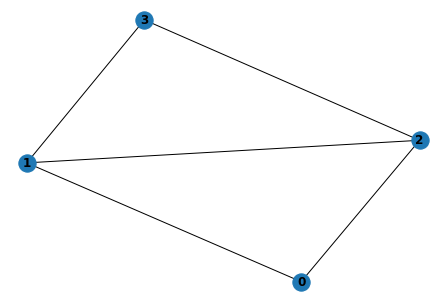

In [130]:
PS = np.array([[1,1,3, 2],[2,2,3, 1],[3,3,3,0], [0, 1, 0, 0]])
test = PauliGraph(PS)
nx.draw(test, with_labels=True, font_weight='bold')

In [122]:
def LDFC(PG):
    SV=sorted(PG.degree, key=lambda x: x[1], reverse=True)#Sorted Vertices by decreasing degree
    n=PG.number_of_nodes()
    aux=list(np.arange(n))
#     Color=n*np.ones(n) # WHY NOT TO START WITH ZEROS, IF NOT, WHY NOT TO TAKE max(AC)
    Color = np.zeros(n)
    for i in range(n):
        IV=list(list(PG.neighbors(SV[i][0])))#Vertices that are Incompatible with vertex SV[i][0]  # WHY THE ARE TWO LIST OPERATORS??
        IC=Color[IV]#Colors that are assigned to vertices that are incompatible with vertex SV[i]
        AC=[ elem for elem in aux if elem not in IC]#Available colors for vertex SV[i]
        Color[SV[i][0]]=min(AC)
#     MC=int(max(Color)) # This is not always true. Better to use np.unique
    MC = len(np.unique(Color)) - 1
    Groups=[]
    for i in range(MC + 1):
        Groups.append(list(np.argwhere(Color==i)))
    return Color, Groups #Color is an array whose i entry has the color assigned to the i Pauli String.
    #Groups is a list of lists, where the i list comprenhends the arrays assigned to the color i.

In [123]:
PS = np.array([[1,1,3, 2],[2,2,3, 1],[3,3,3,0], [0, 1, 0, 0]])
PG = PauliGraph(PS)
# list(PG.neighbors(1))
Color, Groups = LDFC(PG)
print(Color, Groups)

[0. 1. 2. 0.] [[array([0]), array([3])], [array([1])], [array([2])]]


In [124]:
def TPBgrouping(PS): #PS==Pauli Strings. AM=Admisible Measurements. WC==Well Connected Qubits. 
    #    If we want to group n Pauli arrays of size N, PS should be a matrix of n rows and N columns,
    # each row representing a Pauli string.
    PG=PauliGraph(PS)
    Color, Groups=LDFC(PG)
    N=np.size(PS[0,:])
    Measurements=[]#The list of measurements. Each element will be the total measurement for a certain group. That measurement 
    #will be encoded as an N-array of {0,1,3,4}. 0 will appear in the position k if in the qubit k we can measure with any 
    # basis (will only happen if the k factor of every element of the group is I), 1 will appear in the position k if in the qubit k
    #we can measure with TPBX,...
    for i in range(len(Groups)):
        Mi=[]
        for k in range(N):
            Mi.append(max(PS[Groups[i],k]))
        Measurements.append(Mi)
    return Color, Groups, Measurements

In [125]:
PS = np.array([[1,1,3, 2],[2,2,3, 1],[3,3,3,0], [0, 1, 0, 0]])
temp = TPBgrouping(PS)
print(temp[2])

[[array([1]), array([1]), array([3]), array([2])], [array([2]), array([2]), array([3]), array([1])], [array([3]), array([3]), array([3]), array([0])]]


# Now, let's implement the information about local measurements manually.
This is the commutation table 

In [131]:
Comp=[]
Comp.append([])#This empty list is just to fix notation
Comp.append([[0],[1]])
Comp.append([[0],[2]])
Comp.append([[0],[3]])
Comp.append([[0,0],[1,1],[2,2],[3,3]])  # WHAT MEANS THIS LINE??

length=[]
length.append([])#This empty list is just to fix notation
length.append(1)
length.append(1)
length.append(1)
length.append(2)

# Now, let's implement the grouping code.

In [136]:
def MeasurementAssignment(Vi,Vj,Mi,AM,WC):#This program is the Algorithm 2 of https://arxiv.org/abs/1909.09119. Syntax can
    #be looked in 'grouping(PS,AM,WC)'
    
    # Let's first check for compatibility of Vj with the current assigment of Mi.
    # Mi is a list of local measurement. Each local measurement is encoded as list of two elements. The first one 
    # are the qubits where the local measurement acts and the second is the type of local measurement. For example,
    # if Mi contains {4,(1,2)} it would mean that Mi has the Bell measurement (nº4) as the local measurement acting on 
    # the qubits (1,2).
    N=np.size(Vi)
    U=list(np.arange(N))
    S=0  # WHAT IS THE PURPOSE OF S??
    for LM in Mi:
        if list(Vj[LM[1]]) not in Comp[LM[0]]:  # WHAT IS COMP???
            return Mi, S
        else:
            for s in LM[1]:### SEGURO QUE HAY UNA FORMA MÁS RÁPIDA DE ELIMINAR VARIOS VALORES A LA VEZ DE LA LISTA
                U.remove(s)
    commonfactors=np.argwhere(Vi==Vj)
    for k in commonfactors:
        if k in U:
            U.remove(k)
    PMi=Mi #I create a potential Mi.
    while len(U)!=0:
        for Eps in AM:
            if len(U)>=length[Eps]:
                perm=list(permutations(U,length[Eps])) #length of each local measurement will be manually programmed
                perm=list({*map(tuple, map(sorted, perm))}) #This is a code for eliminating the permutations that
                #are equal up to order for perm. This would reduce the iterations (I believe) without affecting the algorithm,
                #because the WC array will contain all possible permutations, even those that are equal with disitinct order.
                #and if the qubits (l,k) of Vi and Vj are compatible with a certain measurement, the qubits (k,l) of Vi and 
                #Vj will be compatible with other measurement. I should explain this better. 
                for per in perm:
                    #if per in WC: 
                    #This raises an error, so here I have to check the code.
                    if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):
                        PMi.append([Eps,list(per)])
                        for s in per:
                            U.remove(s)
                        break
                else:
                    continue
                break
        else:
            return Mi, S
    S=1
    return PMi, S            

def grouping(PS, AM, WC): #PS==Pauli Strings. AM=Admisible Measurements. WC==Well Connected Qubits. 
    #    If we want to group n Pauli arrays of size N, PS should be a matrix of n rows and N columns,
    # each row representing a Pauli string. 
    #    AM should be a vector containing the admisible measurements in the order of prefered assignenment. 
    #    WC should be a vector containing the pairs of qubits with good connectivity.
    PG=PauliGraph(PS)
    SV=sorted(PG.degree, key=lambda x: x[1], reverse=True)#Sorted Vertices by decreasing degree
    n=np.size(PS[:,0])
    N=np.size(PS[0,:])
    AS=[]#list of strings with assigned measurement
    Groups=[]#list of groups
    Measurements=[]#list of total measurements Mi
    for k in range(n):
        i=SV[k][0]
        if i not in AS:
            Mi=[]#Mi will be the total measurement. It will be a list of local measurements. Each local measurement
            #will appear as a list of two elements. The first will correspond with the local measurement and the second
            # to the qubits. For example, if Mi contains {4,(1,2)} it would mean that Mi has the Bell measurement (nº4)
            #as the local measurement acting on the qubits (1,2)
            GroupMi=[i]
            AS.append(i)
            for l in range(n):
                j=SV[l][0]
                if j not in AS:
                    Mi, S=MeasurementAssignment(PS[i,:],PS[j,:],Mi,AM,WC)#S is the success variable. If Mi is compatible with
                    #Vj S=1 otherwise S=0
                    if S==1:
                        AS.append(j)
                        GroupMi.append(j)
            QWM=list(np.arange(N))#Qubits Without a Measurement assigned by Mi. There, all factors 
            # of the group will be equal or the identity, so we will have to use a TPB measurement.
            for LM in Mi:
                for s in LM[1]:
                    QWM.remove(s)
            for q in QWM:
                TPBq=max(PS[GroupMi,q])
                Mi.append([TPBq,[q]])
            Groups.append(GroupMi)
            Measurements.append(Mi)
            
    return Groups, Measurements

# Test 1: TPB grouping

In [137]:
start=time.time()
PS=np.array([[1,1,3],[2,2,3],[3,3,3]])
print(time.time()-start)
TPBgrouping(PS)

0.00010371208190917969


(array([1., 2., 0.]),
 [[array([2])], [array([0])], [array([1])]],
 [[array([3]), array([3]), array([3])],
  [array([1]), array([1]), array([3])],
  [array([2]), array([2]), array([3])]])

# Test 2: Easy Bell Grouping

In [138]:
start=time.time()
PS=np.array([[1,1,3],[2,2,3],[3,3,3]])
WC=list(np.arange(np.size(PS[0,:])))#One should include all qubits in the WC array, othewise the if loop which checks if 
#the measurement is done in compatible qubits would reject all one qubit measurements.
print(WC)
WC2=permutations(WC,2)#let's suppose that all qubits are pairwise connected
WC.extend(WC2)
print(WC)
print(time.time()-start)
grouping(PS,[4],WC)

[0, 1, 2]
[0, 1, 2, (0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
0.00039696693420410156


<ipython-input-136-ce26647e2f77>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):


([[0, 1, 2]], [[[4, [0, 1]], [3, [2]]]])

# Test 3: No grouping

In [139]:
start=time.time()
PS=np.array([[1,2,3],[3,2,2],[1,3,2]])
WC=list(np.arange(np.size(PS[0,:])))#One should include all qubits in the WC array, othewise the if loop which checks if 
#the measurement is done in compatible qubits would reject all one qubit measurements.
WC2=permutations(WC,2)#let's suppose that all qubits are pairwise connected
WC.extend(WC2)
Groups, Measurements=grouping(PS,[4,3,2,1],WC)
print(time.time()-start, 'seconds')
print('Groups', Groups, 'Measurements', Measurements)

0.0010886192321777344 seconds
Groups [[0], [1], [2]] Measurements [[[1, [0]], [2, [1]], [3, [2]]], [[3, [0]], [2, [1]], [2, [2]]], [[1, [0]], [3, [1]], [2, [2]]]]


<ipython-input-136-ce26647e2f77>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):


In [9]:
from qiskit import IBMQ
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.opflow.list_ops import SummedOp
from qiskit.quantum_info import Pauli
from qiskit.algorithms import VQE

In [10]:
def HeisenbergHamiltonian( J=1, H=1, num_qubits=2, neighbours=[(0,1)] ):
    """
    Qiskit operator of the 3-D Heisemberg Hamiltonian of a lattice of spins.
    
    H = - J Σ_j ( X_j X_{j+1} + Y_j Y_{j+1} + Z_j Z_{j+1} ) - H Σ_j Z_j
    
    input:
        J          : Real. Coupling constant.
        H          : Real. External magnetic field.
        num_qubits : Integer. Number of qubits.
        neighbours : List of tuples. Coupling between the spins.
    output:
        Hamiltonian : SummedOp of Qiskit. Heisenberg Hamiltonian of the system.
    """
    num_op = num_qubits + 3*len(neighbours)
    Hamiltonian_op_x = []    
    Hamiltonian_op_z = []  
    Hamiltonian_coef = num_qubits*[-H] + num_op*[-J]
    
    for idx in range(num_qubits):
        op_x = np.zeros( num_qubits )
        op_z = np.zeros( num_qubits )
        op_z[idx] = 1
        Hamiltonian_op_x.append( op_x.copy() )
        Hamiltonian_op_z.append( op_z.copy() )        
    
    for idx in neighbours:
        op_x = np.zeros( num_qubits )
        op_z = np.zeros( num_qubits )
        op_x[idx[0]] = 1
        op_x[idx[1]] = 1
        Hamiltonian_op_x.append( op_x.copy() )
        Hamiltonian_op_z.append( op_z.copy() )
        op_z[idx[0]] = 1
        op_z[idx[1]] = 1
        Hamiltonian_op_x.append( op_x.copy() )
        Hamiltonian_op_z.append( op_z.copy() )        
        op_x[idx[0]] = 0
        op_x[idx[1]] = 0
        Hamiltonian_op_x.append( op_x.copy() )
        Hamiltonian_op_z.append( op_z.copy() )        
#     Hamiltonian = WeightedPauliOperator( 
#         [ [Hamiltonian_coef[j], Pauli( ( Hamiltonian_op_z[j], Hamiltonian_op_x[j] )) ] 
#          for j in range(num_op) ] )

    Hamiltonian = SummedOp( [ PauliOp(Pauli( ( Hamiltonian_op_z[j], Hamiltonian_op_x[j] )),Hamiltonian_coef[j]) for j in range(num_op) ] )

    return Hamiltonian


def RandomHamiltonian( num_qubits=2, num_paulis=4 ):
    
    idxs = np.random.randint(2, size=(2,num_qubits,num_paulis) )

    Hamiltonian = SummedOp( [ PauliOp(Pauli( ( idxs[0,:,j], idxs[1,:,j] )),1) for j in range(num_paulis) ] )
    
    return Hamiltonian

In [12]:
def Label2Chain(QubitOp):
    """
    Transform a string of Pauli matrices into a numpy array.
    'I' --> 0
    'X' --> 1
    'Y' --> 2
    'Z' --> 3
    
    input:
        QubitOp : SummedOp of Qiskit.
    output:
        ops     : narray of the Pauli operators.
                  ops.shape = ( number_of_operators, number_of_qubits )
        coef    : coefficient of each Pauli operator.
    """
    Dict = {'I' : 0,
            'X' : 1,
            'Y' : 2,
            'Z' : 3}
    ops = [[ Dict.get(idx2) for idx2 in idx.primitive.to_label()] for idx in QubitOp.oplist ]
    coef = [ idx.coeff for idx in QubitOp.oplist ]
    return np.array(ops), coef

In [14]:
QubitOp = HeisenbergHamiltonian( num_qubits=4, neighbours=[(0,1),(1,2),(2,3),(3,0)] )
paulis, coef = Label2Chain(QubitOp)
print( QubitOp, paulis )

SummedOp([
  -1 * IIIZ,
  -1 * IIZI,
  -1 * IZII,
  -1 * ZIII,
  -1 * IIXX,
  -1 * IIYY,
  -1 * IIZZ,
  -1 * IXXI,
  -1 * IYYI,
  -1 * IZZI,
  -1 * XXII,
  -1 * YYII,
  -1 * ZZII,
  -1 * XIIX,
  -1 * YIIY,
  -1 * ZIIZ
]) [[0 0 0 3]
 [0 0 3 0]
 [0 3 0 0]
 [3 0 0 0]
 [0 0 1 1]
 [0 0 2 2]
 [0 0 3 3]
 [0 1 1 0]
 [0 2 2 0]
 [0 3 3 0]
 [1 1 0 0]
 [2 2 0 0]
 [3 3 0 0]
 [1 0 0 1]
 [2 0 0 2]
 [3 0 0 3]]


# Test 4: Nontrivial grouping 

In [18]:
WC = list(np.arange(4))  #One should include all qubits in the WC array, othewise the if loop which checks if 
#the measurement is done in compatible qubits would reject all one qubit measurements.
WC2 = permutations(WC,2) #let's suppose that all qubits are pairwise connected
WC.extend(WC2)
Groups, Measurements = grouping(paulis,[4],WC)
print('Groups', Groups, 'Measurements', Measurements)

Groups [[4, 5, 10, 11, 6, 12], [7, 8, 13, 14, 9, 15], [0], [1], [2], [3]] Measurements [[[4, [2, 3]], [4, [0, 1]]], [[4, [1, 2]], [4, [0, 3]]], [[0, [0]], [0, [1]], [0, [2]], [3, [3]]], [[0, [0]], [0, [1]], [3, [2]], [0, [3]]], [[0, [0]], [3, [1]], [0, [2]], [0, [3]]], [[3, [0]], [0, [1]], [0, [2]], [0, [3]]]]


<ipython-input-4-b37eae86f721>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if (list(Vi[[per]]) in Comp[Eps]) and (list(Vj[[per]]) in Comp[Eps]):
